# Clustering the QPESUMS Data Volume

The **dimension-reduction-then-regression** approach of QPE from QPESUMS dataset seemed not doing well on heavy rainfall cases. The PCA-SVM approach perform well when the rainfall is less than 10mm/hr, but it fails to give rainfall amount larger than 15mm/hr. The reason of such results could be that the distribution of rainfall is highly skewed. When there is no rain in most of the cases, the heavy rainfall events that really caused impacts are relatively rare.

Follow this reasoning, we are interested in whether the dimension reduction technique should be applied to the whole dataset or separate datasets with different rainfall amount. Hence, we are trying to perform clustering on the QPESUMS data volume (6 * 275 * 162), and see the rainfall distribution of each cluster. Theoretically, if different clusters show different rainfall distribution, then the dimension-reduction technique can probably be applied to the whole dataset without problems. 

Also, we would like to further compare the results of DR on different rainfall, e.g.,
- Divide all t-x-y data-volume into 3 categories:
  - 0: rain-1mm
  - 1: rain-10mm
  - 2: rain
- Perform PCA on set (0), (1), and (2)
  - Select different K PCs for each category: k0, k1, k2
  - X = {k0 of PCA(0), k1 of PCA(1), k2 of PCA(2)}


### Load library

In [2]:
# load library
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Clustering with Dimension-Reduced Data

We first read in the dimension-reduced input data, and then perform the simple hierarchical clustering.

### Convolutional Auto-Encoder

In [4]:
# Auto-encoder
data_ae = pd.read_csv('../dr_conv_ae/input_ae.csv', index_col=0)
print(data_ae.shape)
print(data_ae.head())

(34369, 88)
                   0         1         2         3         4         5  \
2013010102  1.034368  0.146775  0.946444  0.313138  0.159485  0.414488   
2013010103  1.041885  0.233625  0.518447  0.341125  0.123385  0.452619   
2013010104  1.075873  0.097337  0.520178  0.388773  0.123385  0.117377   
2013010105  0.659602  0.186871  0.696278  0.311820  0.123385  0.117920   
2013010106  0.658156  0.057113  0.741501  0.426976  0.181829  0.257606   

                   6         7         8         9  ...        78        79  \
2013010102  0.123104  0.475972  0.123385  0.485257  ...  0.178794  1.154733   
2013010103  0.120650  0.485176  0.123385  0.307186  ...  0.180623  1.186485   
2013010104  0.111221  0.117377  0.123385  0.214910  ...  0.177330  1.381113   
2013010105  0.123385  0.117377  0.123385  0.287448  ...  0.178794  1.601949   
2013010106  0.115020  0.247851  0.123385  0.391843  ...  0.178794  1.555991   

                  80        81        82        83        84        

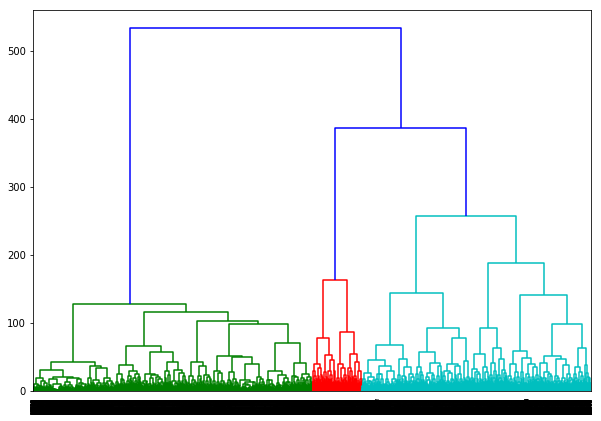

In [5]:
# And then we show the denfrogram to see how many clusters is optimal
#from scipy.cluster.hierarchy import dendrogram, linkage

#linked = linkage(data_ae, 'ward')

#labelList = range(data_ae.shape[0])

#plt.figure(figsize=(10, 7))
#dendrogram(linked,  
#            orientation='top',
#            labels=labelList,
#            distance_sort='descending',
#            show_leaf_counts=False)
#plt.show()  

From the dendrogram shown above, we can see 3 or 4 clusters is optimal for this dimension-reduced dataset. (we commented off the code since it took a long while to run, and we only need the figure.)

So, now we proceed with the cases of 3 and 4 clusters.

In [6]:
from sklearn.cluster import AgglomerativeClustering
c3_ae = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
c4_ae = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
c3_ae.fit_predict(data_ae)
c4_ae.fit_predict(data_ae)

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [12]:
clab_ae = pd.DataFrame({'c3':c3_ae.labels_, 'c4':c4_ae.labels_}, index=data_ae.index)
print(clab_ae['c3'].value_counts())
print(clab_ae['c4'].value_counts())
clab_ae.to_csv('cluster_labels_ae.csv')

1    17225
0    14084
2     3060
Name: c3, dtype: int64
3    17225
0     7391
1     6693
2     3060
Name: c4, dtype: int64


## Process precipitation data

This section of code process the precipitation data and create tables of *time-by-station* hold the recorded precipitation. This pre-processing had been run in the notebook `show_precipitation`, so we just need to load the processed data.

### Load the preprocessed precipitation data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_station_precip(srcdir):
    # List all files to read in the given directory
    import glob,re
    files = glob.glob(srcdir + os.path.sep + '*.csv')
    # Loop through all files
    output = {}
    for f in files:
        # Retrieve station id from the file name
        sta_id = f.replace(srcdir,'').replace('.csv', '')
        tmp = pd.read_csv(f)            # read in data
        time_spans = tmp.keys()[1:]      # get all variables
        # Merge data
        if len(output)==0:
            for t in time_spans:
                output[t] = tmp.loc[:,['date',t]]
                output[t].rename(columns={t: sta_id})
                output[t].columns = ['date', sta_id]
        else:
            for t in time_spans:
                d2 = tmp.loc[:,['date',t]]
                d2.columns = ['date', sta_id]
                output[t] = pd.merge(output[t], d2, on='date')
    return(output)

# Process the data and create table (done previously, so don't have to run again.)
#prep_table = read_station_precip('../precipitation.tpe/')
#for k in prep_table.keys():
#    print(k)
#    prep_table[k].to_csv(k+'.csv', index=False)

t1hr = pd.read_csv('t1hr.csv', index_col=0)
#t3hr = pd.read_csv('t3hr.csv')
#t6hr = pd.read_csv('t6hr.csv')
#t12hr = pd.read_csv('t12hr.csv')
#t24hr = pd.read_csv('t24hr.csv')
#t48hr = pd.read_csv('t48hr.csv')
#t72hr = pd.read_csv('t72hr.csv')
#t120hr = pd.read_csv('t120hr.csv')

print(t1hr.shape)

(35064, 45)


### Process the ranfall data

We have a *time-by-station* table of precipitation, but for demenstrating the distribution of rainfall, we need only one value. Either mean or maximum can be a suitable quantity, here we use maximual rainfall among 45 stations.

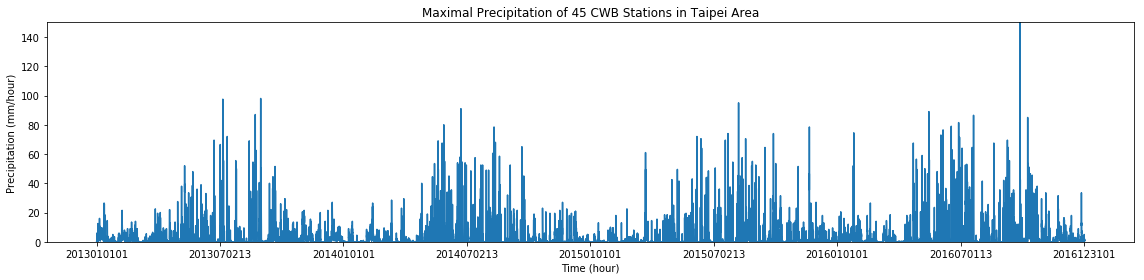

In [14]:
# Extract date-hour as strings
dates = np.array(t1hr.index).astype('str')
# Create new dataframe
t1hr_max = t1hr.max(axis=1)
t1hr_max.index=dates
# Show the time series for checking
plt.figure(figsize=(16,4))
plt.plot(t1hr_max)
plt.xticks(np.arange(0, len(t1hr_max), 4380), list(dates[np.arange(0, len(t1hr_max), 4380)]))
plt.ylim(0,150)
plt.xlabel('Time (hour)')
plt.ylabel('Precipitation (mm/hour)')
plt.title('Maximal Precipitation of 45 CWB Stations in Taipei Area')
plt.tight_layout()
plt.show()

### Maximal rainfall by cluster

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[13056   629   212    91    45    31    12     4     3     1]
[9.27009372e-01 4.46606078e-02 1.50525419e-02 6.46123260e-03
 3.19511502e-03 2.20107924e-03 8.52030673e-04 2.84010224e-04
 2.13007668e-04 7.10025561e-05]


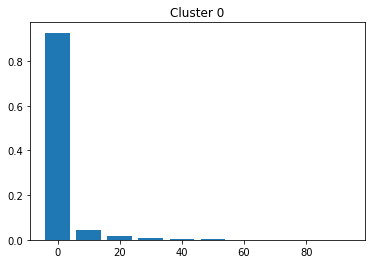

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[16717   327    78    39    26    17    12     5     2     2]
[9.70507983e-01 1.89840348e-02 4.52830189e-03 2.26415094e-03
 1.50943396e-03 9.86937591e-04 6.96661829e-04 2.90275762e-04
 1.16110305e-04 1.16110305e-04]


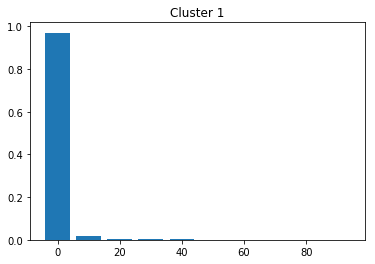

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[2446  336  130   72   32   24    7    6    3    3]
[0.79960771 0.10983982 0.04249755 0.0235371  0.01046093 0.0078457
 0.00228833 0.00196143 0.00098071 0.00098071]


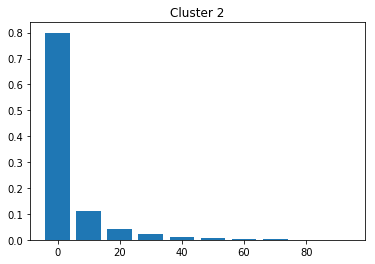

In [41]:
t1hr_max.index=t1hr.index
clab_ae = pd.read_csv('cluster_labels_ae.csv', index_col=0)
# For the case of 3 clusters
for i in range(3):
    # Retrieve the precipitation records of the cluster
    c3idx = clab_ae.index[clab_ae['c3']==i]
    pmax_c3idx = t1hr_max.loc[c3idx]
    # Calculate histogram
    hist, be = np.histogram(pmax_c3idx, bins=10, range=(0,100))
    density = (hist/sum(hist))
    # Show histogram
    print(be)
    print(hist)
    print(density)
    plt.bar(be[:-1], density, width=8)
    plt.title('Cluster '+str(i))
    plt.show()

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[6768  373  129   61   29   19    7    3    2    0]
[9.15708294e-01 5.04667839e-02 1.74536599e-02 8.25328102e-03
 3.92369098e-03 2.57069409e-03 9.47097822e-04 4.05899066e-04
 2.70599378e-04 0.00000000e+00]


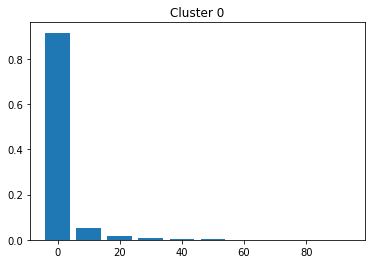

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[6288  256   83   30   16   12    5    1    1    1]
[9.39489018e-01 3.82489168e-02 1.24010160e-02 4.48229494e-03
 2.39055730e-03 1.79291797e-03 7.47049156e-04 1.49409831e-04
 1.49409831e-04 1.49409831e-04]


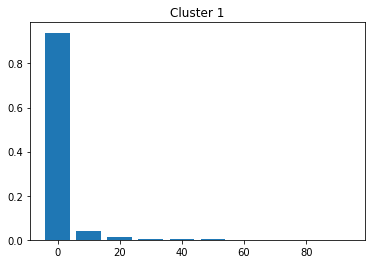

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[2446  336  130   72   32   24    7    6    3    3]
[0.79960771 0.10983982 0.04249755 0.0235371  0.01046093 0.0078457
 0.00228833 0.00196143 0.00098071 0.00098071]


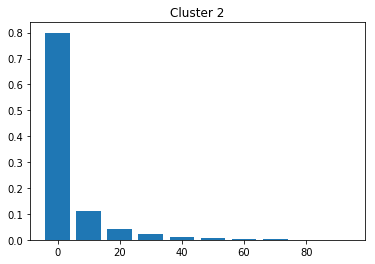

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[16717   327    78    39    26    17    12     5     2     2]
[9.70507983e-01 1.89840348e-02 4.52830189e-03 2.26415094e-03
 1.50943396e-03 9.86937591e-04 6.96661829e-04 2.90275762e-04
 1.16110305e-04 1.16110305e-04]


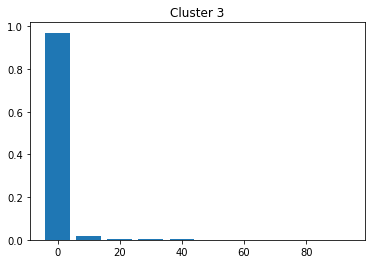

In [42]:
for i in range(4):
    # Retrieve the precipitation records of the cluster
    c3idx = clab_ae.index[clab_ae['c4']==i]
    pmax_c3idx = t1hr_max.loc[c3idx]
    # Calculate histogram
    hist, be = np.histogram(pmax_c3idx, bins=10, range=(0,100))
    density = (hist/sum(hist))
    # Show histogram
    print(be)
    print(hist)
    print(density)
    plt.bar(be[:-1], density, width=8)
    plt.title('Cluster '+str(i))
    plt.show()

As shown in the figures above, the clusters **2** does associate with larger rainfall. However, the heavy rainfall cases also show on other clusters, which indicates the features we derived from auto-encoder do not separate different rainfall strengths.

This is the case we use "maximal rainfall among 45 station", what if we only look at one station?

Index(['C0A580', 'C0A970', '466940', 'C0A540', 'C0A550', 'C0A9A0', 'C0AC60',
       'C0A870', '466920', 'C0A520', 'C0A9F0', 'C0ACA0', 'C0A640', 'C0AD10',
       '466880', 'C0AD00', 'C0A650', 'C0A9G0', 'C0A530', '466930', 'C0A860',
       'C0AC70', 'C0AC40', 'C0AD30', 'C0A890', 'C0AH00', 'C0A660', 'C0AC80',
       'C0AG90', 'C0A710', 'C0A9E0', 'C0A880', 'C0AD20', 'C0A920', '466910',
       'C0A9I1', 'C0AD50', 'C0A9B0', 'C0A560', 'C0A950', 'C0A940', 'C0A570',
       'C0A980', 'C0A9C0', 'C0AD40'],
      dtype='object')
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[12969    86    20    11     3     1     1     0     0     0]
[9.90680620e-01 6.56939882e-03 1.52776717e-03 8.40271943e-04
 2.29165075e-04 7.63883584e-05 7.63883584e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


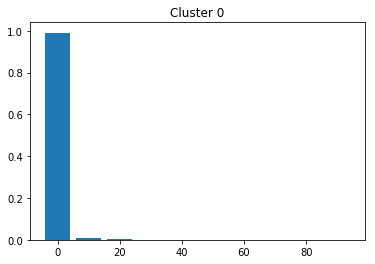

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[16527    31     4     2     0     0     0     0     0     0]
[9.97766240e-01 1.87152862e-03 2.41487563e-04 1.20743782e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


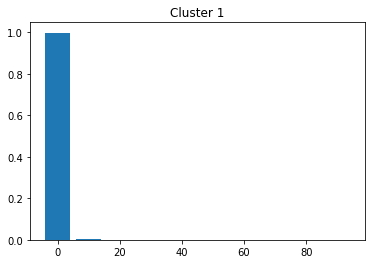

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[2734   67   17   14    5    3    2    0    0    0]
[9.61998593e-01 2.35749472e-02 5.98170303e-03 4.92610837e-03
 1.75932442e-03 1.05559465e-03 7.03729768e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


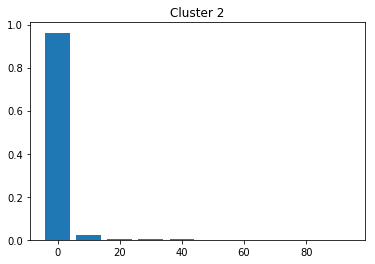

In [45]:
print(t1hr.columns)
# Create new dataframe
t1hr_920 = t1hr.loc[:,'466930']
# For the case of 3 clusters
for i in range(3):
    # Retrieve the precipitation records of the cluster
    c3idx = clab_ae.index[clab_ae['c3']==i]
    p920_c3idx = t1hr_920.loc[c3idx]
    # Calculate histogram
    hist, be = np.histogram(p920_c3idx, bins=10, range=(0,100))
    density = (hist/sum(hist))
    # Show histogram
    print(be)
    print(hist)
    print(density)
    plt.bar(be[:-1], density, width=8)
    plt.title('Cluster '+str(i))
    plt.show()

It seems like if we use the rainfall of one single station, the 0st and 2nd cluster kind of give a mix results. This results suggest that it may worth the effort to perform dimension reduction on different subset of QPESUMS data by its corresponding precipitation.